In [1]:
import os
import xarray as xr
from config import CP1Evaluator, CP1Trainer
import matplotlib.pyplot as plt
from graphufs.stacked_utils import convert_loss_channel2var, get_channel_index
import cartopy.crs as ccrs

In [2]:
emulator = CP1Evaluator()
which_data = "training"
_preprocessed_data_loc = os.path.join(emulator.local_store_path, which_data)

In [3]:
inputs = xr.open_zarr(os.path.join(_preprocessed_data_loc, "inputs.zarr"))
targets = xr.open_zarr(os.path.join(_preprocessed_data_loc, "targets.zarr"))

In [4]:
inputs

<xarray.Dataset> Size: 6TB
Dimensions:   (channels: 281, sample: 37983, lat: 192, lon: 384)
Coordinates:
  * channels  (channels) int64 2kB 0 1 2 3 4 5 6 ... 274 275 276 277 278 279 280
  * lat       (lat) float64 2kB 89.82 88.89 87.95 87.01 ... -87.25 -88.18 -89.12
  * lon       (lon) float64 3kB 0.0 0.9375 1.875 2.812 ... 357.2 358.1 359.1
  * sample    (sample) int64 304kB 0 1 2 3 4 5 ... 37978 37979 37980 37981 37982
Data variables:
    inputs    (sample, lat, lon, channels) float64 6TB dask.array<chunksize=(1, 192, 384, 16), meta=np.ndarray>

In [26]:
targets

<xarray.Dataset> Size: 3TB
Dimensions:   (channels: 133, lat: 192, lon: 384, sample: 37983)
Coordinates:
  * channels  (channels) int64 1kB 0 1 2 3 4 5 6 ... 126 127 128 129 130 131 132
  * lat       (lat) float64 2kB 89.82 88.89 87.95 87.01 ... -87.25 -88.18 -89.12
  * lon       (lon) float64 3kB 0.0 0.9375 1.875 2.812 ... 357.2 358.1 359.1
  * sample    (sample) int64 304kB 0 1 2 3 4 5 ... 37978 37979 37980 37981 37982
Data variables:
    targets   (sample, lat, lon, channels) float64 3TB dask.array<chunksize=(1, 192, 384, 16), meta=np.ndarray>

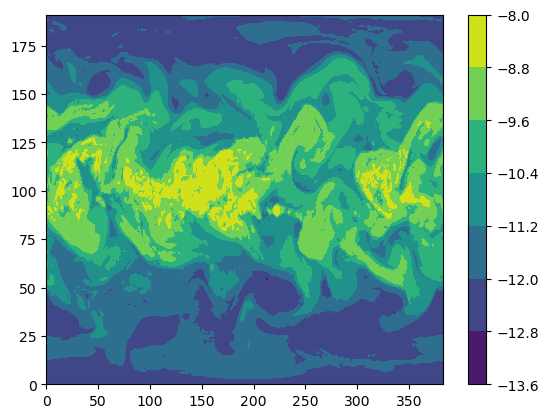

In [8]:
plt.contourf(inputs["inputs"].isel(channels=74, sample=0))
plt.colorbar()
plt.show()

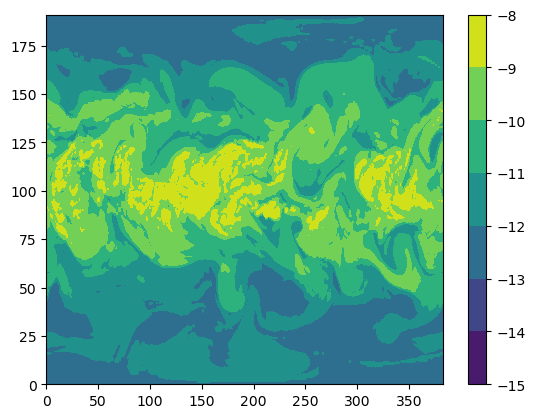

In [9]:
plt.contourf(targets["targets"].isel(channels=34, sample=0))
plt.colorbar()
plt.show()

### Diagnosing the range of input/target channels and identifying ones with too large values

In [ ]:
# minmax of each channel -- Inputs
min_per_channel = inputs["inputs"].min(dim=("sample", "lat", "lon")).load()
max_per_channel = inputs["inputs"].max(dim=("sample", "lat", "lon")).load()
range_per_channel_inputs = max_per_channel - min_per_channel

# minmax of each channel -- Targets
min_per_channel = targets["targets"].min(dim=("sample", "lat", "lon")).load()
max_per_channel = targets["targets"].max(dim=("sample", "lat", "lon")).load()
range_per_channel_targets = max_per_channel - min_per_channel

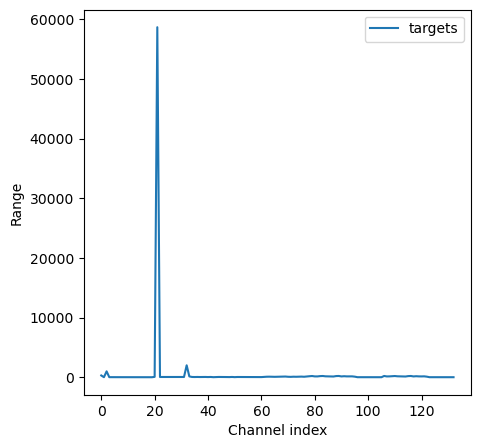

In [45]:
# Plot
fig, ax = plt.subplots(1, 1, figsize=(5,5))
#ax.plot(range_per_channel_inputs.coords["channels"], range_per_channel_inputs,
#       label="inputs")
ax.plot(range_per_channel_targets.coords["channels"], range_per_channel_targets,
       label="targets")
ax.set_xlabel("Channel index")
ax.set_ylabel("Range")
plt.legend()
plt.show()

In [ ]:
th_val = 2000
awry_ch = range_per_channel_targets.where(range_per_channel_targets > th_val, drop=True)
awry_ch

### Identifying awry channels in the loss statistics

In [5]:
loss_stat_loc = emulator.local_store_path
loss = xr.open_dataset(os.path.join(loss_stat_loc, "loss.nc"))
loss

<xarray.Dataset> Size: 86MB
Dimensions:                (optim_step: 151872, epoch: 64, channel: 133)
Coordinates:
  * optim_step             (optim_step) int64 1MB 0 1 2 ... 151869 151870 151871
  * epoch                  (epoch) int64 512B 1 2 3 4 5 6 ... 59 60 61 62 63 64
  * channel                (channel) int64 1kB 0 1 2 3 4 ... 128 129 130 131 132
Data variables:
    loss                   (optim_step) float32 607kB ...
    loss_by_channel        (optim_step, channel) float32 81MB ...
    loss_by_channel_valid  (epoch, channel) float32 34kB ...
    loss_avg               (epoch) float32 256B ...
    loss_valid             (epoch) float32 256B ...
    mgrad                  (epoch) float32 256B ...
    g_norm                 (optim_step) float64 1MB ...
    learning_rate          (optim_step) float32 607kB ...
    epoch_label            (optim_step) float64 1MB ...
Attributes:
    batch_size:  16

In [6]:
th_loss = 1
awry_ch_loss = loss["loss_by_channel"].where(loss["loss_by_channel"] > th_loss, drop=True)
print("Awry Channels' Loss:\n", awry_ch_loss)

Awry Channels' Loss:
 <xarray.DataArray 'loss_by_channel' (optim_step: 151872, channel: 17)> Size: 10MB
array([[3.2018843e+03, 2.9740903e+03, 5.8903571e+02, ..., 1.5177886e+00,
        1.6501919e+01,           nan],
       [3.0952480e+03, 2.8239673e+03, 5.5194934e+02, ..., 1.4432962e+00,
        1.5859132e+01,           nan],
       [3.3885884e+03, 2.9363770e+03, 5.7908490e+02, ..., 1.6108947e+00,
        1.6185017e+01,           nan],
       ...,
       [5.1386700e+02, 2.1424835e+02, 6.3512985e+01, ...,           nan,
        3.7356033e+00,           nan],
       [4.7650159e+02, 2.2964328e+02, 6.7418251e+01, ...,           nan,
        3.7356591e+00,           nan],
       [4.6914716e+02, 2.3498772e+02, 6.6944817e+01, ...,           nan,
        3.9179349e+00,           nan]], dtype=float32)
Coordinates:
  * optim_step  (optim_step) int64 1MB 0 1 2 3 4 ... 151868 151869 151870 151871
  * channel     (channel) int64 136B 34 35 36 37 38 39 40 ... 45 46 47 48 49 50


In [7]:
loss_by_var = convert_loss_channel2var(CP1Trainer, loss.loss_by_channel)

Initialized training dataset object <graphufs.datasets.Dataset object at 0x7fcf0bbd8c10>
xinputs from the first sample of tds <xarray.Dataset> Size: 103MB
Dimensions:            (batch: 1, z_l: 10, time: 2, lat: 192, lon: 384,
                        level: 16)
Coordinates:
  * batch              (batch) int64 8B 0
  * level              (level) float64 128B 226.1 676.2 773.6 ... 922.6 572.7
  * lon                (lon) float64 3kB 0.0 0.9375 1.875 ... 357.2 358.1 359.1
  * lat                (lat) float64 2kB 89.82 88.89 87.95 ... -88.18 -89.12
    datetime           (time) datetime64[ns] 16B 1993-12-31T18:00:00 1994-01-01
  * z_l                (z_l) float64 80B 0.5154 2.765 7.648 ... 271.2 417.7
  * time               (time) timedelta64[ns] 16B -1 days +18:00:00 00:00:00
Data variables: (12/27)
    temp               (batch, z_l, time, lat, lon) float64 12MB dask.array<chunksize=(1, 10, 1, 192, 384), meta=np.ndarray>
    ugrd               (batch, time, level, lat, lon) float32 9MB 

In [6]:
loss_by_var

<xarray.Dataset> Size: 82MB
Dimensions:     (optim_step: 151872, level: 16, z_l: 10)
Coordinates:
  * optim_step  (optim_step) int64 1MB 0 1 2 3 4 ... 151868 151869 151870 151871
  * level       (level) float64 128B 226.1 676.2 773.6 ... 825.8 922.6 572.7
  * z_l         (z_l) float64 80B 0.5154 2.765 7.648 15.95 ... 152.1 271.2 417.7
Data variables: (12/22)
    LW          (optim_step) float32 607kB 4.41e-05 4.365e-05 ... 1.153e-05
    SSH         (optim_step) float32 607kB 2.613e-05 2.4e-05 ... 1.069e-05
    SW          (optim_step) float32 607kB 2.172e-05 1.906e-05 ... 1.793e-05
    dzdt        (level, optim_step) float32 10MB 1.319e-05 ... 0.000211
    icec        (optim_step) float32 607kB 1.441e-05 1.363e-05 ... 1.141e-05
    icetk       (optim_step) float32 607kB 1.558e-05 1.494e-05 ... 1.196e-05
    ...          ...
    ugrd        (level, optim_step) float32 10MB 1.061e-05 ... 2.434e-05
    ugrd10m     (optim_step) float32 607kB 2.061e-05 2.082e-05 ... 1.97e-05
    uo          (z_l, optim_step) float32 6MB 5.763e-05 5.881e-05 ... 1.241e-08
    vgrd        (level, optim_step) float32 10MB 7.972e-06 ... 2.754e-05
    vgrd10m     (optim_step) float32 607kB 2.544e-05 2.491e-05 ... 2.055e-05
    vo          (z_l, optim_step) float32 6MB 1.212e-05 1.248e-05 ... 1.352e-08

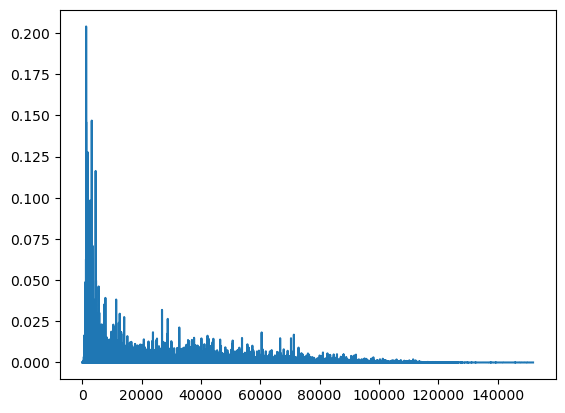

In [10]:
plt.plot(loss_by_var.SSH)
plt.show()